# Proxy

In [1]:
# import library
import sympy as sp
import numpy as np
import matplotlib.pyplot as plt
import copy

Allostery:
<div>
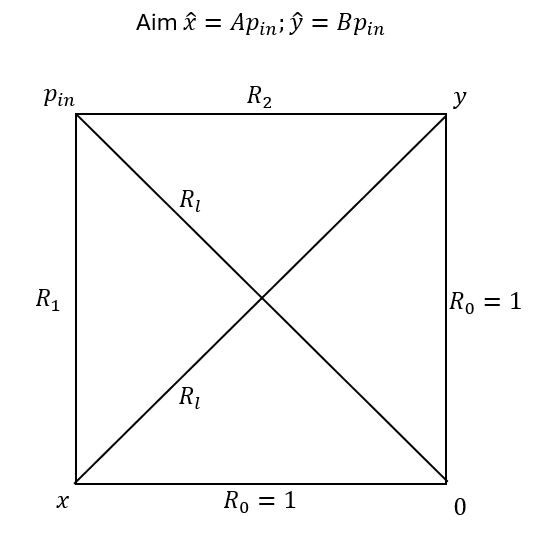
</div>


In [2]:
## Classes

class Variabs():
    def __init__(self, task_type, alpha, gamma):
        super(Variabs, self).__init__()
        self.task_type = task_type
        self.alpha = alpha
        self.gamma = gamma

class Syms():
    def __init__(self, variabs):
        super(Syms, self).__init__()
        if variabs.task_type == 'Allostery':
            self.x, self.y, self.R1, self.R2, self.Rl, self.p = sp.symbols('x, y, R1, R2, Rl, p')    
        elif variabs.task_type == 'Regression':
            self.x, self.R1, self.R2, self.Rl, self.p1, self.p2 = sp.symbols('x, R1, R2, Rl, p1, p2') 
        elif bariabs.task_type == 'General_Reg':
            self.x, self.R1, self.R2, self.Rl, self.p1, self.p2 = sp.symbols('x, y, z R1, R2, R3, R4, R5, R6, R7, R8, R9, \
                                                                             Rl, p1, p2, p3,') 

class State():
    def __init__(self, syms, variabs, supress_prints, bc_noise):
        super(State, self).__init__()
        self.syms = syms
        self.variabs = variabs
        
        # self.R_in_t = [np.array([2.59272486, 5.18544973])]
        self.R_in_t = [np.array([1.,1.])]
        self.out_in_t = []
        self.loss_in_t = []
        self.t = 0
        
        if self.variabs.task_type == 'Allostery':
            self.out_dual_in_t = [np.array([0.5,0.5])]
            self.p_in_t = [1]
            self.loss_fn = loss_fn_allostery
        elif self.variabs.task_type == 'Regression':
            self.out_dual_in_t = [np.array([0.5])]
            # self.p_in_t = [np.array([0.5, 1.5])]
            self.p_in_t = [np.array([1, 1])]
            self.p_drawn_in_t = []
            self.desired_in_t = []
            self.loss_fn = loss_fn_regression
            
        self.supress_prints = supress_prints
        self.bc_noise=bc_noise
        
    def assign_P(self, syms):
        if self.variabs.task_type == 'Allostery':
            self.P = (syms.p-syms.x)**2/syms.R1 + (syms.p-syms.y)**2/syms.R2 + syms.x**2 + syms.y**2 + \
                     syms.p**2/syms.Rl + (syms.x-syms.y)**2/syms.Rl 
        elif self.variabs.task_type == 'Regression':
            self.P = (syms.p1-syms.x)**2/syms.R1 + (syms.p2-syms.x)**2/syms.R2 + syms.p1**2 + syms.p2**2 + \
                     syms.x**2/syms.Rl + (syms.p1-syms.p2)**2/syms.Rl
            
    def solve_pressure(self, syms):        
        if self.variabs.task_type == 'Allostery':
            dPdx = self.P.diff(syms.x)
            dPdy = self.P.diff(syms.y)
            sols = sp.solve([dPdx,dPdy],[syms.x,syms.y])
            self.x = sols[syms.x]
            self.y = sols[syms.y]
        elif self.variabs.task_type == 'Regression':
            dPdx = self.P.diff(syms.x)
            sols = sp.solve([dPdx],[syms.x])
            self.x = sols[syms.x]
    
    def calc_output(self, syms):
        if self.variabs.task_type == 'Allostery':
            # substitute the last resistances and initial input pressure in theoretical expression for pressure at output
            x_nxt = self.x.subs({syms.R1:self.R_in_t[-1][0],syms.R2:self.R_in_t[-1][1],syms.p:self.p_in_t[0],
                                 syms.Rl:2**(1/2)})
            y_nxt = self.y.subs({syms.R1:self.R_in_t[-1][0],syms.R2:self.R_in_t[-1][1],syms.p:self.p_in_t[0],
                                 syms.Rl:2**(1/2)})
            self.output = np.array([x_nxt, y_nxt])
        elif self.variabs.task_type == 'Regression':
            # substitute the last resistances and initial input pressure in theoretical expression for pressure at output
#             x_nxt = self.x.subs({syms.R1:self.R_in_t[-1][0],syms.R2:self.R_in_t[-1][1],syms.p1:self.p_in_t[-1][0],
#                                  syms.p2:self.p_in_t[-1][1], syms.Rl:2**(1/2)})
#             x_nxt = self.x.subs({syms.R1:self.R_in_t[-1][0],syms.R2:self.R_in_t[-1][1],syms.p1:self.p_in_t[0][0],
#                                  syms.p2:self.p_in_t[0][1], syms.Rl:2**(1/2)})
            x_nxt = self.x.subs({syms.R1:self.R_in_t[-1][0],syms.R2:self.R_in_t[-1][1],syms.p1:self.p_drawn[0],
                                 syms.p2:self.p_drawn[1], syms.Rl:2**(1/2)})
            self.output = x_nxt
        if self.supress_prints:
            pass
        else:
            print('output=', self.output)
        self.out_in_t.append(self.output)
    
    def calc_loss(self, desired, output_prev=0, desired_prev=0):
        if self.variabs.task_type=='Allostery':
            self.loss = self.loss_fn(self.output, desired)
        elif self.variabs.task_type=='Regression':
            self.loss = self.loss_fn(self.output, output_prev, desired, desired_prev)
        self.loss_in_t.append(self.loss)
        
    def update_pressure(self):
        self.t += 1
        loss = self.loss_in_t[-1]
        p = self.p_in_t[-1]
        pert = np.random.normal(size=np.size(p))
        if self.variabs.task_type == 'Allostery':
            # p_nxt = p - np.dot(state.variabs.alpha, loss) * self.t
            # p_nxt = p - np.dot(2*(1-np.e**-(state.variabs.alpha*self.t)), loss)
            # p_nxt = p - np.dot(self.variabs.alpha, loss*(1+self.bc_noise*pert))
            # p_nxt = p - np.dot(self.variabs.alpha, loss)       
            p_nxt = p - np.dot(self.variabs.alpha, loss+self.bc_noise*pert)
        elif self.variabs.task_type == 'Regression':
            p_drawn = self.p_drawn_in_t[-1]
            p_prev = self.p_drawn_in_t[-2]
            p_nxt = p - np.dot(self.variabs.alpha, np.dot(p_drawn-p_prev, loss[0]-loss[1]))
            print('the dot for p', np.dot(self.variabs.alpha, np.dot(p_drawn-p_prev, loss[0]-loss[1])))
        if self.supress_prints:
            pass
        else:
            print('loss=', loss)
            print('time=', self.t)
            print('p_nxt=', p_nxt)
        self.p_in_t.append(p_nxt)
        
    def update_BCs(self, desired):
        loss = self.loss_in_t[-1]
        pert = np.random.normal(size=np.size(self.output))
        out_dual = self.out_dual_in_t[-1]
        if self.variabs.task_type=='Allostery':
            # self.output = self.out_in_t[-1] + 2*(1-np.e**-(state.variabs.alpha*self.t)) * self.loss_in_t[-1]
            # self.output = self.out_dual_in_t[-1] + self.variabs.alpha * self.loss_in_t[-1] * (1+self.bc_noise*pert)
            # self.output = self.out_dual_in_t[-1]
            # self.output = np.array([desired])
            self.output = out_dual + self.variabs.alpha * (loss + self.bc_noise*pert)
        elif self.variabs.task_type=='Regression':
            print('output', self.output)
            print('output_prev', self.out_in_t[-2])
            self.output = out_dual + self.variabs.alpha * np.dot(self.output-self.out_in_t[-2], loss[0]-loss[1])
            # self.output = out_dual + self.variabs.alpha * (loss[0]-loss[1])
        self.out_dual_in_t.append(self.output)           
        if self.supress_prints:
            pass
        else:
            print('dual output', self.output)
    
    def update_Rs(self):
        # R_nxt = R_in_t[-1] + self.variabs.gamma * (self.p_in_t[-1]-self.output) 
        # self.R_in_t.append(self.variabs.gamma * (self.p_in_t[-1]-self.output[-1]))
        self.R_in_t.append(self.variabs.gamma * (self.p_in_t[-1]-self.output))
        if self.supress_prints:
            pass
        else:
            print('R_nxt', self.R_in_t[-1])
            
    def draw_p(self):
        self.p_drawn = np.random.uniform(low=0.0, high=2.0, size=2)
        self.p_drawn_in_t.append(self.p_drawn)
        # self.p_in_t[-1] = p_drawn
        # x=5
        
    def update_alpha(self, alpha):
        if self.variabs.task_type == 'Allostery':
            self.variabs.alpha = np.array([alpha, alpha])
        else:
            self.variabs.alpha = alpha
        # print('new alpha=', self.variabs.alpha)

In [6]:
## functions

def run_model_changing_alpha(alpha_vec, task_type, training, supress, bc_noise=0):
    if task_type=='Allostery':
        alpha_vec = np.column_stack((alpha_vec, alpha_vec))
        gamma = np.array([1.0, 1.0])  # how much resistance changed due to pressure difference
        x_hat = 0.2
        y_hat = 0.3
        desired = np.array([x_hat, y_hat])
        A = copy.copy(x_hat)
        B = copy.copy(y_hat)
    elif task_type=='Regression':
        gamma = np.array([1.0])  # how much resistance changed due to pressure difference
        A = 0.4
        B = 0.25
        AB_vec = np.array([A, B])  # this is in terms of A & B, the calculated desired pressure is calculated in train loop
    
    for j, alpha in enumerate(alpha_vec):
#        print(alpha)
        ## classes for variables and symbols
        variabs = Variabs(task_type, alpha, gamma)
        syms = Syms(variabs)

        ## network state
        state = State(syms, variabs, supress_prints=supress, bc_noise=bc_noise)
        state.assign_P(syms)
        state.solve_pressure(syms)
        
        for i in range(training):
            if task_type=='Allostery':
                if np.size(alpha)>2:  # if alpha is annealed, change. In allostery alpha is 2D anyway
                    state.update_alpha(alpha[i])
                state.calc_output(syms)
                state.calc_loss(desired)
                state.update_pressure()
                state.update_BCs(desired)
                state.update_Rs()
            elif task_type=='Regression':
                if not i % 1:
                    if np.size(alpha)>1:
                        state.update_alpha(alpha(i))
                        print()
                    state.draw_p()
                    desired = np.dot(AB_vec, state.p_drawn)
                    state.desired_in_t.append(desired)
                    if supress:
                        pass
                    else:
                        print('p_drawn', state.p_drawn)
                        print('desired', desired)
                state.calc_output(syms)
                
                if not i % 2:
                    pass
                else:
                    state.calc_loss(desired, state.out_in_t[-2], state.desired_in_t[-2])
                    state.update_pressure()
                    state.update_BCs(desired)
                    state.update_Rs()               
                       
        # print(state.p_in_t)
        plot_importants(state, variabs, desired, A, B)
    return state, variabs, desired
            
def plot_importants(state, variabs, desired, A=1, B=1):
    if variabs.task_type == 'Allostery':
        A = desired[0]/state.p_in_t[0]  # A = x_hat/p_in
        B = desired[1]/state.p_in_t[0]  # B = y_hat/p_in
        Rl_subs = 2**(1/2)
        R_theor = state.p_in_t[0]*np.array([(1-A)/(A*(1+1/Rl_subs)-B/Rl_subs), (1-B)/(B*(1+1/Rl_subs)-A/Rl_subs)])
        legend1 = ['x', 'y', 'x desired', 'y deisred']
        legend2 = ['x dual', 'y dual', 'p dual']
        legend3 = ['R1', 'R2', 'R1 theoretical', 'R2 theoretical']
    elif variabs.task_type == 'Regression':
        Rl_subs = 2**(1/2)
        R_theor = np.array([Rl_subs*(1-A-B)/A, Rl_subs*(1-A-B)/B])
        legend1 = ['x', 'x desired']
        legend2 = ['x dual', 'p1 dual', 'p2 dual']
        legend3 = ['R1', 'R2', 'R1 theoretical', 'R2 theoretical']
    legend4 = ['|loss|']
    print('R theoretical', R_theor)

    fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(12, 5))
    if variabs.task_type=='Allostery':
        ax1.plot(state.out_in_t[1:], '.')
        ax1.plot(np.outer(desired,np.ones(state.t)).T, '--')
    elif variabs.task_type=='Regression':  # regression goes only every two samples
        ax1.plot(np.linspace(0, state.t, 2*state.t-1).T, state.out_in_t[1:])
        ax1.plot(np.linspace(0, state.t, 2*state.t).T, state.desired_in_t, '--')
    ax1.set_title('output in time')
    ax1.set_xlabel('t')
    ax1.legend(legend1)
    ax2.plot(state.out_dual_in_t[1:])
    ax2.plot(state.p_in_t[1:])
    ax2.set_title('dual and p in time')
    ax2.set_xlabel('t')
    ax2.legend(legend2)
    ax3.plot(state.R_in_t[1:])
    ax3.plot(np.outer(R_theor,np.ones(state.t)).T, '--')
    ax3.set_title('R in time')
    ax3.set_xlabel('t')
    ax3.legend(legend3)
    ax4.plot(np.abs(state.loss_in_t[1:]))
    ax4.set_xlabel('t')
    ax4.legend(legend4)
    fig.suptitle(f'alpha={variabs.alpha}')
    plt.show()
    # print(state.R_in_t)

def loss_fn_allostery(output, desired):
    # return np.sign(desired-output)
    # return np.e**(-(desired-output)
    return desired-output
    # return np.sign(desired-output) * np.e**(-np.abs((desired-output)))
    
def loss_fn_regression(output1, output2, desired1, desired2):
    L1 = desired1-output1
    L2 = desired2-output2
    return np.array([L1, L2])

In [7]:
## Parameters

# learning rate
# alpha_vec = np.array([0.2, 0.5, 1.0, 2.0, 2.5, 2.7, 3.5, 4.0, 8.0])  # 1D array = const alpha, array of arrays = annealed
# alpha_vec = np.array([np.append(np.linspace(4.1,4.8,200), np.linspace(4.8,4.1,200))])  # 1D array for constant alpha, array of arrays for annealed alpha
alpha_vec = np.array([1.0])
# alpha_vec = np.array([np.linspace(5,3.85,40)])  # 1D array for constant alpha, array of arrays for annealed alpha
# alpha_vec = np.array([4.8])

# task - allostery or regression by now
task_type = 'Regression'
# task_type = 'Allostery'

# training length
if np.size(alpha_vec[0])>1:  # if alpha is annealed
    training=len(alpha_vec[0])
else:
    training=220

p_drawn [1.16730557 1.25057864]
desired 0.7795668885678108
output= 0.893161742611841
p_drawn [0.31199485 1.99334777]
desired 0.6231348836363816
output= 0.851589098568857
the dot for p [0.0982404428756167 -0.0853139881652983]
loss= [-0.228454214932476 -0.113594854044030]
time= 1
p_nxt= [0.901759557124383 1.08531398816530]
output 0.851589098568857
output_prev 0.893161742611841
dual output [0.504775007325220]
R_nxt [0.396984549799163 0.580538980840078]
p_drawn [1.46533006 1.57001178]
desired 0.9786349687021397
output= 1.29238804918733
p_drawn [1.62995388 1.23144673]
desired 0.9598432335274192
output= 1.25833719757306
the dot for p [0.00251201399150070 -0.00516620348692970]
loss= [-0.298493964045642 -0.313753080485186]
time= 2
p_nxt= [0.899247543132883 1.09048019165223]
output 1.25833719757306
output_prev 1.29238804918733
dual output [0.504255421415572]
R_nxt [0.394992121717310 0.586224770236656]
p_drawn [0.97364237 1.01759148]
desired 0.6438548175824987
output= 0.849568576024244
p_drawn [

output= 0.551655903533766
p_drawn [1.54764393 1.85147208]
desired 1.0819255949587048
output= 1.11649917704287
the dot for p [-0.0171144047024315 -0.00251278615901143]
loss= [-0.0345735820841631 -0.0210162651758760]
time= 22
p_nxt= [1.24400992369092 1.87607251784737]
output 1.11649917704287
output_prev 0.551655903533766
dual output [0.0790971479228725]
R_nxt [1.16491277576805 1.79697536992450]
p_drawn [0.32006348 1.70604161]
desired 0.5545357972331659
output= 0.576876351978916
p_drawn [1.41921471 1.78119195]
desired 1.0129838718264248
output= 1.04122802326350
the dot for p [-0.00648894555070638 -0.000443657264121307]
loss= [-0.0282441514370741 -0.0223405547457496]
time= 23
p_nxt= [1.25049886924163 1.87651617511149]
output 1.04122802326350
output_prev 0.576876351978916
dual output [0.0763558029326658]
R_nxt [1.17414306630896 1.80016037217883]
p_drawn [1.91441633 1.9358939 ]
desired 1.249740007192874
output= 1.27980097883359
p_drawn [0.0779283  0.17940227]
desired 0.07602188906336778
outp

output= 1.01526476611018
p_drawn [0.34117637 0.44334559]
desired 0.2473069430186809
output= 0.247679229090358
the dot for p [-0.000247094804363915 -0.000137127572471792]
loss= [-0.000372286071677053 -0.000545751957699459]
time= 48
p_nxt= [1.27224821259230 2.00101696603354]
output 0.247679229090358
output_prev 1.01526476611018
dual output [0.0350526388258814]
R_nxt [1.23719557376641 1.96596432720766]
p_drawn [0.91522709 1.6573494 ]
desired 0.7804281837220819
output= 0.781989704765273
p_drawn [0.09425564 0.7180916 ]
desired 0.21722515581984897
output= 0.218101470705102
the dot for p [-0.000562534690935197 -0.000643585226054473]
loss= [-0.000876314885253388 -0.00156152104319096]
time= 49
p_nxt= [1.27281074728323 2.00166055125960]
output 0.218101470705102
output_prev 0.781989704765273
dual output [0.0346662591355148]
R_nxt [1.23814448814772 1.96699429212408]
p_drawn [1.42185186 1.35683278]
desired 0.9079489404327223
output= 0.908566825160415
p_drawn [1.77723708 1.36413992]
desired 1.051929

output= 0.205884447630195
p_drawn [1.25229641 0.9393455 ]
desired 0.7357549386424077
output= 0.735860630679836
the dot for p [-6.71088107720997e-5 -1.85800574486976e-5]
loss= [-0.000105692037428717 -4.62703679027232e-5]
time= 77
p_nxt= [1.27019693853426 2.01196949214674]
output 0.735860630679836
output_prev 0.205884447630195
dual output [0.0331244101683958]
R_nxt [1.23707252836587 1.97884508197834]
p_drawn [1.00782895 1.86784572]
desired 0.8700930109194934
output= 0.870242047041921
p_drawn [1.06531012 0.84561109]
desired 0.6375268176723845
output= 0.637604899530241
the dot for p [4.07853376286242e-6 -7.25319068444265e-5]
loss= [-7.80818578560716e-5 -0.000149036122427226]
time= 78
p_nxt= [1.27019286000050 2.01204202405358]
output 0.637604899530241
output_prev 0.870242047041921
dual output [0.0331079035706821]
R_nxt [1.23708495642982 1.97893412048290]
p_drawn [0.78124858 1.51140854]
desired 0.6903515698481975
output= 0.690461967206373
p_drawn [0.43987667 1.33934493]
desired 0.51078689970

output= 1.22544937974242
p_drawn [1.97373973 1.29946587]
desired 1.1143623566425487
output= 1.11444005948507
the dot for p [2.02697746574644e-6 -9.45702190744602e-6]
loss= [-7.77028425225090e-5 -9.16986076384685e-5]
time= 98
p_nxt= [1.27020143894068 2.01244049752417]
output 1.11444005948507
output_prev 1.22544937974242
dual output [0.0330048334021039]
R_nxt [1.23719660553857 1.97943566412207]
p_drawn [1.7418062  0.31473915]
desired 0.7754072686713129
output= 0.775455374396101
p_drawn [0.31907904 0.92877505]
desired 0.35982537791643693
output= 0.359855501939774
the dot for p [-2.55830550455463e-5 1.10414101206901e-5]
loss= [-3.01240233374078e-5 -4.81057247885275e-5]
time= 99
p_nxt= [1.27022702199572 2.01242945611405]
output 0.359855501939774
output_prev 0.775455374396101
dual output [0.0329973602092742]
R_nxt [1.23722966178645 1.97943209590478]
p_drawn [0.81457083 0.76712793]
desired 0.5176103155653418
output= 0.517644918133339
p_drawn [0.46506502 0.51531456]
desired 0.3148546472404892


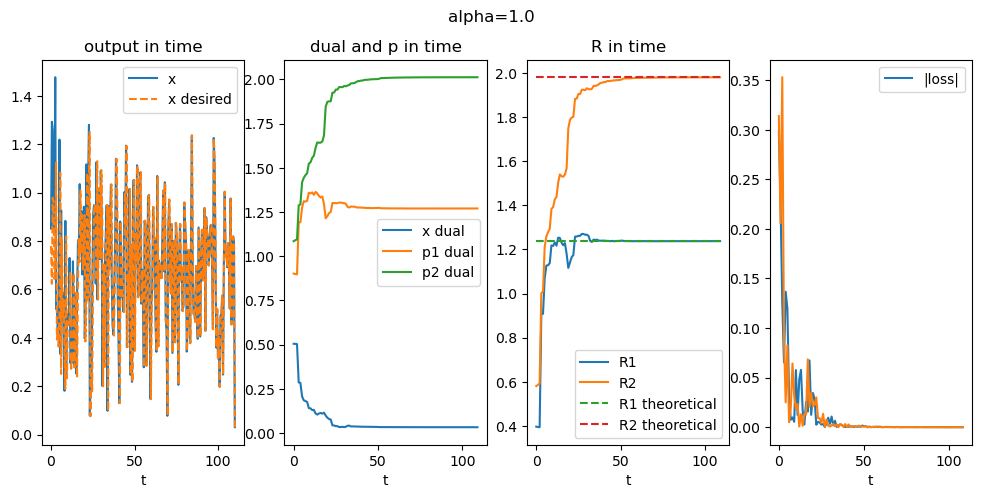

In [8]:
# Training + plot

state, variabs, desired = run_model_changing_alpha(alpha_vec, task_type, training, supress=False, bc_noise=0.0)

Text(0, 0.5, '$x,y$')

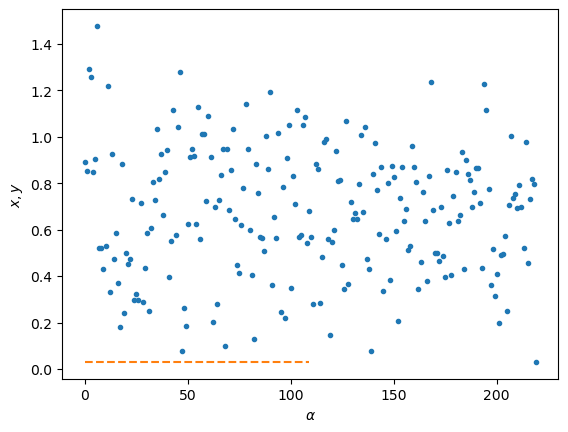

In [9]:
## plot the hysteresis curve
# it will work only if alpha is the same size as t

if len(alpha_vec.T) == len(state.out_in_t):
    plt.plot(alpha_vec.T, state.out_in_t, '.')
    plt.plot(np.outer(desired,np.ones(state.t)).T, '--')
    plt.xlim([min(alpha_vec[0])-0.01, max(alpha_vec[0]+0.01)])
else:
    plt.plot(state.out_in_t, '.')
    plt.plot(np.outer(desired,np.ones(state.t)).T, '--')
plt.xlabel(r"$\alpha$")
plt.ylabel(r"$x,y$")